## Overview --

This is the third in a series of three notebooks for the project on predicting BQs at the 2013-17 Boston Marathon.

*Previous notebooks - *

**BOS_1_import**: Imported data from 2013-17, calculated metrics, performed some exploratory data analysis (EDA), cleaned/wrangled data, outputted giant CSV file

**BOS_2_EDA**: Continued EDA, compiled some tables and plots, established a prediction baseline

*This notebook -*

**BOS_3_machine**: Perform machine learning (classification) with training set consisting of 2013-16 data and test set comprised of 2017 data

### Import modules, timing mat variables, and functions

In [1]:
# load modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
#from helperFunctions import BQlookup2, get_sec, get_time

np.set_printoptions(precision=3)
pd.set_option('max_colwidth',120)

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, \
    roc_curve, average_precision_score, roc_auc_score
    
# SKLEARN classifiers
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold, \
    StratifiedShuffleSplit, train_test_split

from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# timing mat information
marDist = 26.21875 # marathon distance in miles
fiveK = 3.106856 # 5K distance in miles
halfDist = 0.5*marDist # half marathon distance in miles
mats = [fiveK, fiveK*2, fiveK*3, fiveK*4, halfDist, fiveK*5, fiveK*6, fiveK*7, fiveK*8, marDist]
timingmats = {i+1:mats[i] for i in range(len(mats))}
# dictionary: timingmats[1] = 5K, timingmats[2] = 10K, etc

In [3]:
# define 3 functions: BQlookup2, get_sec, get_time
def BQlookup2(gender, age):
    '''
    Find BQ requirement, given gender & age
    example usage: BQlookup2('M',30) returns '3:05:00'
    '''
    # gender & age are scalars
    if gender == "NA":
        BQreq = "?"
    elif age == "NA":
        BQreq = "?"
  
    if gender == 'M':
        if age < 35:
            BQreq = "3:05:00"
        elif age < 40:
            BQreq = "3:10:00"
        elif age < 45:
            BQreq = "3:15:00"
        elif age < 50:
            BQreq = "3:25:00"
        elif age < 55:
            BQreq = "3:30:00"
        elif age < 60:
            BQreq = "3:40:00"
        elif age < 65:
            BQreq = "3:55:00"
        elif age < 70:
            BQreq = "4:10:00"
        elif age < 75:
            BQreq = "4:25:00"
        elif age < 80:
            BQreq = "4:40:00"
        else:
            BQreq = "4:55:00"
    
    elif (gender == 'F'):
        if (age < 35):
            BQreq = "3:35:00"
        elif (age < 40):
            BQreq = "3:40:00"
        elif (age < 45):
            BQreq = "3:45:00"
        elif (age < 50):
            BQreq = "3:55:00"
        elif (age < 55):
            BQreq = "4:00:00"
        elif (age < 60):
            BQreq = "4:10:00"
        elif (age < 65):
            BQreq = "4:25:00"
        elif (age < 70):
            BQreq = "4:40:00"
        elif (age < 75):
            BQreq = "4:55:00"
        elif (age < 80):
            BQreq = "5:10:00"
        else:
            BQreq = "5:25:00"

    return BQreq

def get_sec(s):
# takes in text string 'HH:MM:SS.mss' and returns time in seconds
# can also be in MM:SS form
    import numpy as np

    try:
        if s == 'DNF':
            return np.NaN
        elif s == 'DSQ':
            return np.NaN
        elif s == 'DQ':
            return np.NaN
        elif s == 'N/A':
            return np.NaN
        elif s == 'nan':
            return np.NaN
        #elif s.isspace() == True:
        elif len(s) < 3: # deals with '' or ' ' cases (empty string or space)
        # can probably do this: s.isspace() == True:
        # can probably use .isnumeric() to filter out non-strings
            return np.NaN
        else:
            l = s.split(':')
            if len(l) == 3:
                if l[0][0] != '-':
                    return int(l[0]) * 3600 + int(l[1]) * 60 + (float(l[2])) # took out int(float...)
                else: # negative!
                    return int(l[0]) * 3600 - int(l[1]) * 60 - (float(l[2]))
        #needed to deal with the case of milliseconds in finish time: truncate to seconds
            elif len(l) == 2:
                if l[0][0] != '-':
                    return int(l[0]) * 60 + (float(l[1]))
                else: # negative!
                    return int(l[0]) * 60 - (float(l[1]))
            else:
                return "bad format!!"
    except TypeError:
        # this catches NaN inputs when "len(s) < 3" is checked
        return np.NaN
    
def get_time(sec):
# takes in number (can be a decimal) and returns text string 'H:MM:SS'
# or '[M]M:SS' if less than 1 hour
    import math
    import numpy as np
    
    if sec == '':
        return ''
    elif np.isnan(sec) == True:
        return ''
    
    if sec < 0:
        sign = "-"
    else:
        sign = ""
    
    sec = round(sec)

    if abs(sec) >= 60*60: # if the time is greater than one hour
        hours = int(math.floor(abs(sec) / 3600))
        minutes = int(math.floor((abs(sec)-hours*3600) / 60))
        if minutes < 10:
            minutes = '0' + str(int(minutes))
        else:
            minutes = str(int(minutes))
        seconds = abs(sec) - hours*3600 - int(minutes)*60
        if seconds < 10:
            seconds = '0' + str(int(seconds))
        else:
            seconds = str(int(seconds))
        return sign + str(hours) + ":" + minutes + ":" + seconds
    elif abs(sec) < 60*60 and abs(sec) >= 60:
        # if the time is less than 1 hour but greater than 1 minute
        minutes = int(math.floor(abs(sec) / 60))
        seconds = abs(sec) - int(minutes)*60
        if seconds < 10:
            seconds = '0' + str(int(seconds))
        else:
            seconds = str(int(seconds))
        return sign + str(minutes) + ":" + seconds
    elif abs(sec) < 60:
        seconds = abs(int(sec))
        if seconds < 10:
            seconds = '0' + str(int(seconds))
        else:
            seconds = str(int(seconds))
        return sign + "0:" + seconds

In [4]:
def calculate_paces(target_cpaces, age=30, sex_int=0, start_t=50, bib_mod=18000):
    '''
    Inputs --
    target_cpaces: list with 5 elements containing projected cumulative paces 
        (string format: "MM:SS" in min/mi) at the first 5 timing mats -- 5K, 10K, 15, 20K, half.
        Also can be a list with 1 element representing "even pace" through halfway
        examples: ['7:00','7:00','7:05','7:05','7:10']; 
            or ['6:00'] (equivalent to ['6:00','6:00','6:00','6:00','6:00'])
    age: age (integer) on day of Boston Marathon
    sex_int: 0 for "M", 1 for "F"
    start_t: projected temperature (degrees F) at Hopkinton when crossing the starting line
    bib_mod: projected bib# (integer)
    
    Outputs --
    cum_paces, cum_scores, split_paces, split_scores, stdpaces, 
        [BQpace_sec, age, sex_int, bib_mod, wave, start_t]
    '''
#splitpacescores = ['split12_score','split23_score','split34_score','split45_score','split35_score','split25_score']
#splitpaces = ['split12','split23','split34','split45','split35','split25']
#cumpacescores = ['split1_score','split2_score','split3_score','split4_score','split5_score']
#cumpaces = ['split1','split2','split3','split4','split5']
    if len(target_cpaces) == 1:
        cum_paces = [get_sec(target_cpaces[0])] * 5
    elif len(target_cpaces) == 5:
        cum_paces = [get_sec(x) for x in target_cpaces]
    else:
        return "error: target_cpaces not in correct format!"

    # calculate cumulative & split paces
    cum_splits = (np.array(cum_paces) * np.array(mats[0:5]))
    split_paces = list( (np.array(cum_splits[1:5]) - np.array(cum_splits[0:4]) )*1.0 / (np.array(mats[1:5]) - np.array(mats[0:4])))\
                    + [(cum_splits[-1]-cum_splits[-3])*1.0/(timingmats[5]-timingmats[3])]\
                    + [(cum_splits[-1]-cum_splits[-4])*1.0/(timingmats[5]-timingmats[2])]
        
    # calculate "wave" based on projected bib #
    if bib_mod < 8000:
        wave = 1
    elif bib_mod < 16000:
        wave = 2
    elif bib_mod < 24000:
        wave = 3
    else:
        wave = 4
        
    # calculate BQ requirement & pace, before finding pace "scores"
    sex = "M" if sex_int==0 else "F"
    BQreq = BQlookup2(sex,age+1)
    BQpace_sec = get_sec(BQreq) * 1.0/marDist
    
    # calculate pace "scores"
    cum_scores = np.array(cum_paces) - np.array([BQpace_sec]*len(cum_paces))
    split_scores = np.array(split_paces) - np.array([BQpace_sec]*len(split_paces))
    
    # calculate stdpace at the 3rd-5th timing mats
    stdpaces = [np.std([cum_paces[0]]+split_paces[0:2],ddof=1),
                np.std([cum_paces[0]]+split_paces[0:3],ddof=1),
                np.std([cum_paces[0]]+split_paces[0:4],ddof=1)]

    return cum_paces, cum_scores, split_paces, split_scores, stdpaces, [BQpace_sec, age, sex_int, bib_mod, wave, start_t]

calculate_paces(['6:50','6:55','6:50','6:50','6:50'],40,1)
#calculate_paces(['6:50'],40,0)

([410.0, 415.0, 410.0, 410.0, 410.0],
 array([-104.899,  -99.899, -104.899, -104.899, -104.899]),
 [420.00000000000006,
  399.99999999999994,
  410.0,
  410.0,
  410.0,
  405.49447819593269],
 array([ -94.899, -114.899, -104.899, -104.899, -104.899, -109.404]),
 [10.000000000000057, 8.164965809277307, 7.0710678118655155],
 [514.8986889153755, 40, 1, 18000, 3, 50])

### Import data

In [5]:
# import data, add features as necessary
print(datetime.now().strftime("%A, %d %B %Y %I:%M:%S%p"))

filename = "BOSexample.csv"

boscomplete = pd.read_csv(filename, low_memory=False) # large file!!
# file contains official results from 2013-17 Boston
print(len(boscomplete))

# some fields contain lists that are read in as strings
# use "eval" to convert them to lists
# however, these fields aren't used as features, so these commands aren't entirely necessary
boscomplete['non_missing_splitpaces_time'] = boscomplete.non_missing_splitpaces_time.str.replace("'","")
for x in ['mm','non_missing_mats','non_missing_cumpaces','non_missing_splitpaces']:
    boscomplete[x] = boscomplete[x].apply(eval)

print(datetime.now().strftime("%A, %d %B %Y %I:%M:%S%p"))

Thursday, 28 June 2018 07:41:19AM
129153
Thursday, 28 June 2018 07:41:35AM


### Removing/fixing timing anomalies

There are a few cases of timing anomalies that are prime candidates for removal -- 
1. Runners who record a split pace faster than 4:20/mi anywhere along the course
2. Runners who have a fast split pace at the end (between 40K and the finish line) and a slow split pace at the beginning (between the starting line and 5K)
3. Runners whose times don't make temporal sense
4. Known cheaters

Most anomalies fall into more than one of the above categories, and they have to do with chip time adjustments. For example, a runner's chip might not register at the starting line, and so the timing system treats her split times as both chip & gun times. (Most runners have gun times greater than chip times, because gun times begin at the start of each wave, but chip times start when runners actually cross the starting line. Depending on which corral a runner starts in, it might take several minutes for a runner to get across the starting line after a wave officially starts.) Boston might give her a faster chip time upon reviewing video from the starting line, but the BAA will leave the split times as-is in the official results. This falls under case (2) above, and the fast finishing split pace might trigger case (1) as well.

Case (3) includes only 1 person: Brian Wright had his 2015 chip time adjusted to 2:58:__81__. (Most likely the BAA intended to adjust Mr Wright's time to 2:59:21. I've made that adjustment.)

The BAA takes issue with cheaters: those who cut the course, or run with someone else's bib, or sell their bib to someone else to run with. They usually remove cheaters from the official results when these cases arise, meaning that cheaters often don't make it into the official results, but sometimes they don't take action. There are __[two](https://www.marathoninvestigation.com/2017/04/boston-marathon-suspicious-results.html)__ __[people](https://www.marathoninvestigation.com/2017/02/boston-registrant-has-history-of.html)__ who have been known to cut the course and whose results remain official -- I've removed them from the dataset here.

In [6]:
# find people with sub-4:20 split anywhere along course
cols = ['year','BQ','bib','name','DIVISION','chip','chip_unofficial','gun','mm','non_missing_splitpaces_time']
anomaly1 = boscomplete[(boscomplete.apply(lambda row: (min(row['non_missing_splitpaces'])<=60*4.33),axis=1)==1)].sort_values(by=['mm_len','stdpace'],ascending=False)
print(len(anomaly1))
(anomaly1[cols])

3


,year,BQ,bib,name,DIVISION,chip,chip_unofficial,gun,mm,non_missing_splitpaces_time
128741,2017,0,28020,"Dabene, Paul Jr",M20_24,5:48:01,3:50:53,3:55:08,[7],"[48:33, 11:49, 12:29, 13:13, 12:09, 13:34, 0:15, 8:28, 8:27]"
31244,2014,0,15089,"Potts, Franzine B",F30_34,3:44:06,4:54:28,5:07:28,[],"[7:48, 11:16, 10:24, 10:50, 9:33, 11:41, 11:46, 13:12, 12:56, -39:22]"
48209,2014,0,26680,"Martinovich, Patricia",F45_49,5:50:00,6:08:13,6:16:06,[],"[10:05, 10:53, 11:57, 13:15, 18:14, 15:38, 15:22, 19:53, 14:30, 1:15]"


In [7]:
# find BQs with super-fast split910 split pace due to adjusted chip times
# (slow split1, fast split910)
cols = ['year','BQ','bib','name','DIVISION','chip','chip_unofficial','gun','mm','non_missing_splitpaces_time']
anomaly2 = boscomplete[boscomplete.BQ.isin([1]) 
    & (boscomplete.chip!=boscomplete.chip_unofficial)
    & (boscomplete.split1-boscomplete.split12>=30)
    & (boscomplete.split89-boscomplete.split910>=60)].sort_values(by=['mm_len','stdpace'],ascending=False)
print(len(anomaly2))
(anomaly2[cols])

2


,year,BQ,bib,name,DIVISION,chip,chip_unofficial,gun,mm,non_missing_splitpaces_time
19707,2014,1,4632,"Warner, Joshua",M30_34,2:58:52,NaN,NaN,[],"[7:41, 6:45, 6:41, 6:44, 6:40, 6:42, 6:47, 6:54, 7:06, 5:04]"
23861,2014,1,11000,"Rygg, Neisha",F35_39,3:19:14,NaN,NaN,[],"[7:42, 7:06, 7:21, 7:32, 7:17, 7:35, 7:52, 8:03, 7:59, 6:56]"


In [8]:
# find chip times that don't make sense
cols = ['year','BQ','bib','name','DIVISION','chip','chip_unofficial','gun','mm','non_missing_splitpaces_time']
anomaly3 = boscomplete[(boscomplete.apply(lambda row: (int(row['chip'][-5:-3])>59)
                                          or (int(row['chip'][-2:])>59),axis=1)==1)]
(anomaly3[cols])
# Brian Wright's 2015 chip time of 2:58:81 has already been corrected in CSV file to 2:59:21

,year,BQ,bib,name,DIVISION,chip,chip_unofficial,gun,mm,non_missing_splitpaces_time


In [9]:
# find known cheaters
cols = ['year','BQ','bib','name','age','chip','mm','non_missing_splitpaces_time']
anomaly4 = boscomplete[boscomplete.name.str.contains("(taylor, george)|(koeppe, torsten)",case=False)]\
    .sort_values(by=['age'])
print(len(anomaly4))
(anomaly4[cols])

8


/Users/donwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


,year,BQ,bib,name,age,chip,mm,non_missing_splitpaces_time
20305,2014,1,3385,"Koeppe, Torsten",49,3:02:04,"[7, 8]","[6:50, 6:48, 6:48, 6:53, 6:51, 7:04, 6:59, 7:34]"
52441,2015,1,2006,"Koeppe, Torsten",50,3:01:23,"[7, 8]","[6:55, 6:49, 6:48, 6:58, 6:56, 7:07, 6:53, 7:05]"
79571,2016,1,4727,"Koeppe, Torsten",51,3:13:07,"[7, 8]","[6:51, 6:53, 7:07, 7:32, 7:40, 9:28, 6:48, 9:47]"
7426,2013,1,8882,"Taylor, George F",59,3:26:14,[],"[7:56, 7:02, 6:56, 8:26, 8:02, 7:13, 7:28, 7:17, 9:50, 9:12]"
28971,2014,1,14369,"Taylor, George F",60,3:36:44,[],"[7:55, 7:55, 7:05, 7:10, 7:54, 8:25, 8:06, 7:33, 11:09, 10:25]"
61700,2015,1,19316,"Taylor, George",61,3:36:12,[4],"[8:43, 7:34, 7:15, 7:48, 7:31, 7:15, 7:53, 10:00, 12:34]"
83567,2016,1,19749,"Taylor, George",62,3:29:06,[4],"[8:47, 7:25, 7:15, 7:58, 7:30, 7:24, 7:54, 9:03, 8:58]"
109691,2017,1,15324,"Taylor, George",63,3:29:33,[4],"[9:34, 7:07, 7:36, 7:12, 7:45, 7:23, 7:06, 9:46, 9:18]"


Recall that **mm** stands for "missing mats". In Mr Koeppe's case, he missed timing mats at 30K and 35K in multiple years. It's clear that something fishy happened in 2016 (a hot year), when he slowed down to 9:28/mi pace from 21.1-25K, but then covered 25-40K at 6:48/mi pace. A plausible explanation is that he stepped off the course and took the metro to get closer to the finish. That Mr Koeppe got away with it for so long shows that the Boston Athletic Association wasn't in the habit of checking its own race results. (Mr Koeppe successfully registered for 2017 Boston but had his entry rescinded by the BAA after these examples were brought to light a few months prior to the race.)

In [10]:
# remove anomalies
print(len(boscomplete))
boscomplete = boscomplete.ix[sorted(set(boscomplete.index) - set(anomaly1.index) 
    - set(anomaly2.index) - set(anomaly3.index) - set(anomaly4.index))]
print(len(boscomplete))

129153
129140


### Create training & test sets

The goal is to predict BQs in 2017 based on models trained using 2013-16 data.

Training set: 2013-16 data

Test set: 2017 data

In [11]:
# apportion the dataset into training & test sets, then shuffle
# set the random state so that the shuffling is reproducible

train_df = boscomplete[~boscomplete.year.isin([2017])].sample(frac=1, random_state=123)
test_df = boscomplete[boscomplete.year.isin([2017])].sample(frac=1, random_state=456)
print(len(train_df))
print(len(test_df))

102741
26399


### Review of relevant features for predicting BQs

__*splitX*__: cumulative pace, at timing mat #X, in seconds per mile. (*split10* would be a runner's final pace, since timing mat #10 is at the finish line)

__*splitXY*__: split pace between timing mat #X & #Y, in seconds per mile. (For example, *split34* represents a runner's split pace between timing mats 3 & 4, or 15K and 20K)

__*BQpace_sec*__: minimum required pace to qualify for Boston, dependent on a runner's age & gender, in seconds per mile

__*splitX_score*__: *splitX - BQpace_sec* (non-positive values indicate runner is going faster than his/her BQ pace through mat X)

__*splitXY_score*__: *splitXY - BQpace_sec* (non-positive values indicate runner is going faster than his/her BQ pace between mats X & Y)

__*stdpace_matX*__: standard deviation of a runner's split paces up until timing mat #X. (For example, stdpace_mat3 would be calculated as the standard deviation of [split1, split12, split23])

__*age*__: runner's age on the day of running the Boston Marathon (integer)

__*sex_int*__: 0 for men, 1 for women

__*start_t*__: projected starting temperature at the time the runner crosses the starting line in Hopkinton, MA, in degrees F (float)

__*wave*__: possible values are 0-4, where lower values represent faster runners. (Elites are in Wave 0; charity runners are in Wave 4)

__*bib_mod*__: integer form of *bib* (elite women have "F" in their bib numbers, so *bib_mod* removes the "F"). The faster the runner (based on time submitted for entry), the lower the *bib_mod* assigned.

#### Target variable for classification --

__*BQ*__: 1 if runner BQs, 0 if not

### Machine learning: classification

We'll try 2 different kinds of classifiers: **gradient boosting machines** and **K-nearest neighbors**.

Why only 2? Well, the idea was to pick different classifiers from opposite ends of the complexity spectrum, with K-nearest neighbors (KNN) being the simple choice and gradient boosting machines the advanced model.

Through trial and error, I saw that gradient boosting performed the best in terms of accuracy. So, let's stick with the best and discard the others (random forest, decision trees, logistic regression, SVM, etc), save for KNN.

#### Gradient boosting machines

It's an ensemble method that doesn't require scaling the features (though we'll still go ahead and use a StandardScaler), and we'll throw in as many features as we can think of.

As with random forest classifiers, gradient boosting machines will try to figure out the feature importances that contribute toward making correct predictions.

With our gradient boosting classifier (GBC), we'll use all the features described above.

GRADIENT BOOSTING CLASSIFIER (default parameters) --

Training set size:
102741 (full set)
102214 (after dropping those with missing splits)

Test set size:
26399 full set
26300 (after dropping those with missing splits)

[[52063  5722]
 [ 3841 40588]]
Training set mistakes: 9563
Training set score: 0.906
             precision    recall  f1-score   support

     non-BQ      0.931     0.901     0.916     57785
         BQ      0.876     0.914     0.895     44429

avg / total      0.907     0.906     0.907    102214

[[16305  1587]
 [  843  7565]]
Test set mistakes: 2430
Test set score: 0.908
             precision    recall  f1-score   support

     non-BQ      0.951     0.911     0.931     17892
         BQ      0.827     0.900     0.862      8408

avg / total      0.911     0.908     0.909     26300



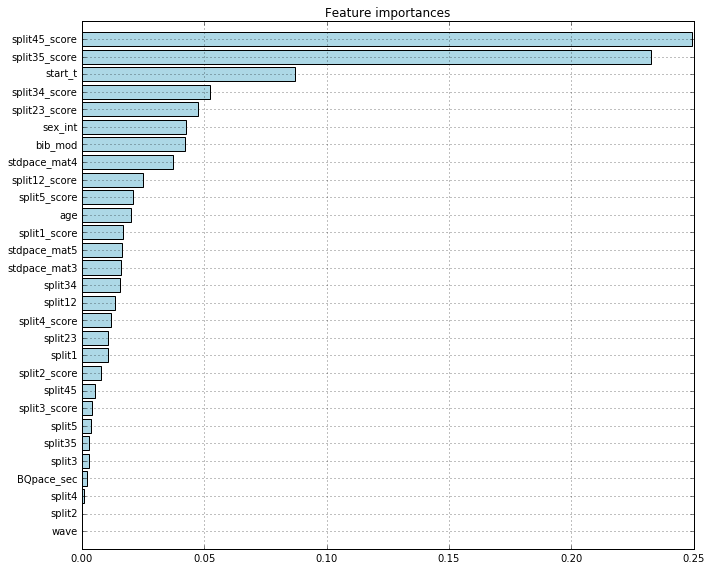

In [12]:
# Gradient Boosting Classifier

splitpacescores = ['split12_score','split23_score','split34_score','split45_score','split35_score']
splitpaces = ['split12','split23','split34','split45','split35']
cumpacescores = ['split1_score','split2_score','split3_score','split4_score','split5_score']
cumpaces = ['split1','split2','split3','split4','split5']
stdpaces = ['stdpace_mat3','stdpace_mat4','stdpace_mat5']

gbc_features = ['BQ','age','sex_int','start_t','wave','bib_mod', 'BQpace_sec'] \
    + splitpacescores + cumpacescores + splitpaces + cumpaces + stdpaces

# trying out using only 10K & halfway for pacing 
#gbc_features = ['BQ','age','sex_int','start_t','wave','bib_mod', 'BQpace_sec',
#    'split2_score','split5_score','split25_score','split2','split5','split25'] + stdpaces

# train & test sets: keeping only those rows that don't have missing values
gbc_X_train = np.array(train_df[gbc_features[1:]].dropna(axis=0,how='any'))
gbc_scaler = StandardScaler()
gbc_X_train_scaled = gbc_scaler.fit_transform(gbc_X_train)
gbc_y_train = np.array(train_df[gbc_features].dropna(axis=0,how='any')['BQ'])
print("GRADIENT BOOSTING CLASSIFIER (default parameters) --\n")
print("Training set size:")
print("{} (full set)".format(len(train_df)))
print("{} (after dropping those with missing splits)".format(len(gbc_y_train)))
print("")

gbc_X_test = np.array(test_df[gbc_features[1:]].dropna(axis=0,how='any'))
gbc_X_test_scaled = gbc_scaler.transform(gbc_X_test)
gbc_y_test = np.array(test_df[gbc_features].dropna(axis=0,how='any')['BQ'])
print("Test set size:")
print("{} full set".format(len(test_df)))
print("{} (after dropping those with missing splits)".format(len(gbc_y_test)))

#defaults: learning_rate=0.1, max_depth=3, n_estimators=100
gbc = GradientBoostingClassifier().fit(gbc_X_train_scaled,gbc_y_train)

print("")
print(confusion_matrix(gbc_y_train, gbc.predict(gbc_X_train_scaled)))
print("Training set mistakes: {}".format((gbc_y_train!=gbc.predict(gbc_X_train_scaled)).sum()))
print("Training set score: {:.3f}".format(gbc.score(gbc_X_train_scaled, gbc_y_train)))
print(classification_report(gbc_y_train, gbc.predict(gbc_X_train_scaled),digits=3,labels=[False,True], target_names=['non-BQ','BQ']))

print(confusion_matrix(gbc_y_test, gbc.predict(gbc_X_test_scaled)))
print("Test set mistakes: {}".format((gbc_y_test!=gbc.predict(gbc_X_test_scaled)).sum()))
print("Test set score: {:.3f}".format(gbc.score(gbc_X_test_scaled, gbc_y_test)))
print(classification_report(gbc_y_test, gbc.predict(gbc_X_test_scaled),digits=3,labels=[False,True], target_names=['non-BQ','BQ']))

# plot feature_importances_ --

indices = np.argsort(gbc.feature_importances_)[::1]
fig, ax = plt.subplots(figsize=(10,8))
plt.barh(range(gbc_X_train.shape[1]), gbc.feature_importances_[indices], color='lightblue',align='center')
plt.yticks(range(gbc_X_train.shape[1]), train_df[gbc_features[1:]].columns[indices])
plt.ylim([-1, gbc_X_train.shape[1]])
plt.grid(which='both',axis='both')
#ax.tick_params(labeltop=True, labelright=False)
plt.title('Feature importances')
plt.tight_layout()
plt.show()

Comment: in the above output we're looking at the number of classification mistakes and the accuracy percentage. Without tuning any parameters we're getting around 0.906 and 0.908 accuracy on the training and test sets, respectively, which is slightly higher than the other common classifiers (logistic regression, random forest, SVM) that we tried. (Most are in the 0.89-0.90 range for the test set.)

From the graph of feature importances, we can see that split pace scores ranked high on the list, especially the ones that covered the portions closest to the midpoint of the race. (Recall that we're using pacing info only up to and including the halfway point. In other words, we're not using split56_score, split67_score, etc.)

Note: I've included **split35_score** as a feature because split45_score covers a shorter distance than the others. split45 covers only 20K to halfway (21.1K), whereas, say, split23 covers a distance of 5K (10K to 15K). Otherwise, I don't use split paces that span more than 2 consecutive timing mats (e.g., split13).

Next, we perform **cross validation** on the training set, still using a GBC with default parameters.

The point of doing cross validation here is to see whether the model overfits the training data. In other words, based on the performance on different folds of the training set, we'll find out whether we need more data to fit a model. If we have X folds, then each fold will act as a test set during the cross validation process, while the other X-1 folds act as the training set. If the cross validation scores are similar across the X folds, then it's a good sign that the training data as a whole might generalize well to unseen data.

Below, we see that the standard deviation of the cross validation scores is fairly low.

In [13]:
# CROSS VALIDATION (gradient boosting classifier)

skip = False
if skip == False:
    # need shuffle=True if training set wasn't shuffled above
    #kfold = KFold(len(gbc_y_train), n_folds=10, shuffle=True, random_state=0)
    #sss = StratifiedShuffleSplit(gbc_y_train, 10, test_size=0.2, random_state=0)
    skfold = StratifiedKFold(gbc_y_train, n_folds=10, shuffle=True, random_state=0)

    scores = cross_val_score(GradientBoostingClassifier(), X=gbc_X_train, y=gbc_y_train, cv=skfold, n_jobs=-1)
    print(scores)
    print(scores.mean())
    print(scores.std())

[ 0.905  0.904  0.905  0.907  0.905  0.9    0.9    0.91   0.907  0.902]
0.904484648612
0.0031207003882


#### K-Nearest Neighbors

Next, we'll swing to the opposite end of the complexity spectrum and try a KNN classifier.

The idea is to classify BQs based on how similar a person paces compared to past Boston participants. We'll even keep to a minimum the number of features that we use to build the classifier: __gender, age group (via BQpace_sec), split pace scores__ and __cumulative pace scores__.

We won't consider *starting temperature, bib number, wave, stdpaces*, and (exact) *age*.

Let's see how well a simple model can perform.

In [14]:
# KNN Classifier

splitpacescores = ['split12_score','split23_score','split34_score','split45_score','split35_score']
cumpacescores = ['split1_score','split2_score','split3_score','split4_score','split5_score']

knn_features = ['BQ','sex_int','BQpace_sec'] \
    + splitpacescores + cumpacescores
    
# trying out using only 10K & halfway mats for pacing info
#knn_features = ['BQ','sex_int','BQpace_sec','split2_score','split25_score','split5_score']

# train & test sets: keeping only those rows that don't have missing values
knn_X_train = np.array(train_df[knn_features[1:]].dropna(axis=0,how='any'))
knn_scaler = StandardScaler()
knn_X_train_scaled = knn_scaler.fit_transform(knn_X_train)
knn_y_train = np.array(train_df[knn_features].dropna(axis=0,how='any')['BQ'])

# train_df after resetting index
knn_train_df_res = train_df.ix[train_df[knn_features[0:]].dropna(axis=0,how='any').index].reset_index(drop=True)

print("K-NEAREST NEIGHBORS (default parameters) --\n")
print("Training set size:")
print("{} (full set)".format(len(train_df)))
print("{} (after dropping those with missing splits)".format(len(knn_y_train)))
print("")

knn_X_test = np.array(test_df[knn_features[1:]].dropna(axis=0,how='any'))
knn_X_test_scaled = knn_scaler.transform(knn_X_test)
knn_y_test = np.array(test_df[knn_features].dropna(axis=0,how='any')['BQ'])
print("Test set size:")
print("{} full set".format(len(test_df)))
print("{} (after dropping those with missing splits)".format(len(knn_y_test)))

#defaults: n_neighbors=5, weights='uniform'
knn = KNeighborsClassifier().fit(knn_X_train_scaled, knn_y_train)
knn_train_predict = knn.predict(knn_X_train_scaled)
knn_test_predict = knn.predict(knn_X_test_scaled)
knn_train_df_res['predict'] = knn_train_predict

# need to subset test_df, by complete cases
knn_test_df = test_df.ix[test_df[knn_features].dropna(axis=0,how='any').index]
knn_test_df['predict'] = knn_test_predict

print("")
print(confusion_matrix(knn_y_train, knn_train_predict))
print("Training set mistakes: {}".format((knn_y_train!=knn_train_predict).sum()))
print("Training set score: {:.3f}".format(knn.score(knn_X_train_scaled, knn_y_train)))
print(classification_report(knn_y_train, knn_train_predict, digits=3,labels=[False,True], target_names=['non-BQ','BQ']))

print(confusion_matrix(knn_y_test, knn_test_predict))
print("Test set mistakes: {}".format((knn_y_test!=knn_test_predict).sum()))
print("Test set score: {:.3f}".format(knn.score(knn_X_test_scaled, knn_y_test)))
print(classification_report(knn_y_test, knn_test_predict, digits=3,labels=[False,True], target_names=['non-BQ','BQ']))


K-NEAREST NEIGHBORS (default parameters) --

Training set size:
102741 (full set)
102214 (after dropping those with missing splits)

Test set size:
26399 full set
26300 (after dropping those with missing splits)

[[52885  4900]
 [ 3306 41123]]
Training set mistakes: 8206
Training set score: 0.920
             precision    recall  f1-score   support

     non-BQ      0.941     0.915     0.928     57785
         BQ      0.894     0.926     0.909     44429

avg / total      0.920     0.920     0.920    102214

[[16113  1779]
 [  975  7433]]
Test set mistakes: 2754
Test set score: 0.895
             precision    recall  f1-score   support

     non-BQ      0.943     0.901     0.921     17892
         BQ      0.807     0.884     0.844      8408

avg / total      0.899     0.895     0.896     26300



From the above, we can see that GBC (with default parameters) outperforms KNN (with default parameters) on the test set (0.908 versus 0.895).

Below, we'll perform cross validation on the default KNN model with the training data, as we had done with the default GBC model earlier. And again, we see that KNN might generalize well to unseen data, due to the small standard deviation of the cross validation scores.

In [15]:
# CROSS VALIDATION (k-nearest neighbors)

skip = False
if skip == False:
    # need shuffle=True if training set wasn't shuffled above
    #kfold = KFold(len(knn_y_train), n_folds=10, shuffle=True, random_state=0)
    #sss = StratifiedShuffleSplit(knn_y_train, 10, test_size=0.2, random_state=0)
    skfold = StratifiedKFold(knn_y_train, n_folds=10, shuffle=True, random_state=0)

    scores = cross_val_score(KNeighborsClassifier(), X=knn_X_train, y=knn_y_train, cv=skfold, n_jobs=-1)
    print(scores)
    print(scores.mean())
    print(scores.std())

[ 0.889  0.889  0.89   0.891  0.89   0.885  0.885  0.896  0.893  0.891]
0.889770496582
0.0032591160316


We can see that an untuned KNN classifier doesn't predict as well as an untuned GBC.

However, an advantage of KNN is that, in addition to making predictions, it can find the k-nearest neighbors of a given pacing plan. This allows the user to see not only BQ predictions, but possible pacing outcomes over the second half of the course given how someone paces the first half.

Therefore, whenever we're searching for the k-nearest neighbors of a given input, the values for the following fields will be similar: __age, pace_1sthalf__, and the __first 5__ values of __non_missing_splitpaces_time__.

We'll first take a brief look at some of the wrong predictions on the training set. When KNN wrongly predicts a BQ, it's usually the case that the runner looked good for the first half, but then slowed down a lot in the second half. When KNN wrongly predicts a non-BQ, it's usually the opposite: the runner wasn't super-fast for the first half, but kept it together in the second half and didn't fade much (if at all).

In [16]:
# KNN: wrong predictions on training set
cols = ['year','BQ','predict','bib','name','age','chip','pace','BQpace','pace_1sthalf','pace_2ndhalf','mm','non_missing_splitpaces_time']
knn_train_df_res[(knn_train_df_res['BQ']!=knn_train_df_res['predict'])][cols].sample(10)

,year,BQ,predict,bib,name,age,chip,pace,BQpace,pace_1sthalf,pace_2ndhalf,mm,non_missing_splitpaces_time
101269,2013,1,0,10818,"Goulette, Tom",48,3:24:49,7:49,7:49,7:43,7:54,[],"[7:43, 7:45, 7:38, 7:45, 7:46, 7:44, 7:59, 8:07, 7:47, 7:49]"
43841,2016,0,1,753,"Niska, Bobby",23,3:05:39,7:05,7:03,6:18,7:51,[],"[6:00, 6:14, 6:23, 6:32, 6:32, 6:54, 7:32, 8:08, 8:19, 8:37]"
101504,2016,0,1,23048,"Mccreesh, Loren",47,4:06:03,9:23,8:58,8:09,10:37,[],"[8:11, 8:06, 8:07, 8:12, 8:11, 8:28, 9:12, 11:22, 12:56, 10:39]"
86632,2016,1,0,11231,"Lawrence, Danielle",30,3:33:03,8:08,8:12,8:04,8:11,[],"[8:00, 8:05, 8:03, 8:11, 7:57, 8:07, 8:15, 8:14, 8:08, 8:10]"
75964,2014,0,1,14733,"Fallon, Jeffrey J",54,3:45:16,8:36,8:23,8:06,9:05,[],"[8:00, 8:05, 8:04, 8:14, 8:05, 8:21, 8:36, 8:58, 9:41, 10:25]"
11675,2014,1,0,19447,"Gonzalez, Jannette",41,3:36:55,8:16,8:35,8:02,8:30,[],"[8:01, 7:56, 8:01, 8:11, 8:05, 8:04, 8:27, 8:38, 8:46, 8:34]"
8370,2015,1,0,19743,"Nester, Jennifer",43,3:43:43,8:32,8:35,8:20,8:44,[],"[8:17, 8:28, 8:12, 8:24, 8:22, 8:29, 8:47, 8:57, 8:44, 8:31]"
82462,2013,0,1,11879,"Barna, Heather",41,3:45:13,8:35,8:35,8:01,9:09,[],"[7:54, 7:54, 8:00, 8:14, 8:17, 8:26, 8:54, 9:29, 9:25, 9:43]"
709,2014,0,1,15945,"Kralj, Heather",35,3:49:24,8:45,8:23,8:03,9:26,[],"[7:55, 7:58, 8:02, 8:21, 7:58, 8:21, 8:56, 10:26, 9:46, 9:33]"
75756,2015,1,0,3302,"Hayden, Lewis R II",41,3:10:15,7:15,7:26,7:14,7:16,[],"[7:16, 7:16, 7:12, 7:15, 7:07, 7:11, 7:20, 7:24, 7:15, 7:07]"


In [17]:
# find neighbors for someone in training set (by index)
# (if we see something strange above, we can take that runner's index # and see his/her neighbors
#  that led to the KNN model's prediction)
cols = ['year','BQ','predict','bib','name','age','chip','pace','BQpace','pace_1sthalf','pace_2ndhalf','mm','non_missing_splitpaces_time']
idx = 75574
knn_train_df_res.ix[knn.kneighbors(knn_X_train_scaled[idx])[1][0]][cols]

,year,BQ,predict,bib,name,age,chip,pace,BQpace,pace_1sthalf,pace_2ndhalf,mm,non_missing_splitpaces_time
75574,2014,0,1,3594,"Przybyla, Mark A",55,3:57:14,9:03,8:23,6:45,11:21,[],"[6:44, 6:46, 6:47, 6:45, 6:46, 6:59, 7:27, 20:30, 10:24, 9:16]"
50494,2015,1,1,4297,"Weintraub, Daniel M",54,3:00:14,6:52,8:23,6:45,6:59,[],"[6:44, 6:44, 6:47, 6:46, 6:43, 6:47, 6:58, 7:06, 6:56, 7:17]"
81829,2014,1,1,1960,"Leaman, Gary A",54,3:04:32,7:02,8:23,6:47,7:17,[],"[6:43, 6:49, 6:49, 6:48, 6:45, 6:52, 6:51, 7:08, 7:27, 9:03]"
18205,2014,1,1,6795,"Shibata, Osamu",54,3:03:08,6:59,8:23,6:44,7:14,[],"[6:43, 6:41, 6:44, 6:48, 6:45, 6:55, 7:06, 7:19, 7:31, 7:16]"
97534,2015,1,1,3191,"Oliver, David E",58,2:58:44,6:49,8:23,6:47,6:51,[],"[6:46, 6:48, 6:48, 6:48, 6:42, 6:44, 6:52, 7:00, 6:47, 6:44]"


### Finding neighbors

Here, we can find neighbors for the following --

1. Runners in the training set
2. Runners in the test set
3. A hypothetical pacing plan to see possible outcomes

Note that the results below won't show many neighbors because we're using the default KNeighborsClassifier with no parameters specified. The default settings have n_neighbors=5. After we run a grid search with cross validation for a better (higher) n_neighbors value to improve accuracy, we can take the new model and repeat what we're doing in this section.

In [18]:
# find neighbors for someone in training set (by year & name)
cols = ['year','BQ','predict','bib','name','age','chip','pace','pace_1sthalf','pace_2ndhalf','mm','non_missing_splitpaces_time']
year = [2015]
name_to_search = "wang, don"
search = knn_train_df_res[knn_train_df_res.year.isin(year) 
        & knn_train_df_res.name.str.contains(name_to_search,case=False)]
idx = search.index#[0]
#knn_train_df_res.ix[knn.kneighbors(knn_X_train_scaled[idx])[1][0]][cols]
knn_train_df_res.ix[list(chain.from_iterable(knn.kneighbors(knn_X_train_scaled[idx])[1]))][cols]

,year,BQ,predict,bib,name,age,chip,pace,pace_1sthalf,pace_2ndhalf,mm,non_missing_splitpaces_time
49979,2015,1,0,3648,"Wang, Don",33,3:02:01,6:57,6:51,7:02,[],"[6:53, 6:46, 6:49, 6:55, 6:54, 6:54, 7:02, 7:08, 7:06, 6:56]"
91851,2014,0,1,5429,"Petruzzello, Tony",25,3:09:12,7:13,6:51,7:35,[],"[6:52, 6:47, 6:49, 6:54, 6:52, 6:56, 7:15, 7:53, 8:00, 7:54]"
58223,2013,0,0,3072,"Puzio, Glenn",26,3:26:29,7:53,6:51,8:55,[],"[6:53, 6:48, 6:48, 6:53, 6:54, 7:06, 8:07, 10:00, 10:40, 7:25]"
28013,2016,0,0,3893,"Tennent, Loren",31,3:06:46,7:07,6:51,7:24,[],"[6:51, 6:45, 6:51, 6:56, 6:55, 7:04, 7:17, 7:28, 7:34, 7:43]"
88194,2014,0,0,4016,"Van Doren, Matthew C",31,3:17:33,7:32,6:51,8:13,[],"[6:52, 6:46, 6:49, 6:57, 6:55, 7:00, 7:37, 8:34, 8:42, 9:49]"


In [19]:
# find neighbors (from training set) for someone in test set (2017)

# search by name: last name, first name
name_to_search = "pope, rob"
test = knn_test_df[(knn_test_df['name'].str.contains(name_to_search,case=False))]
knn_feat_values = test[knn_features[1:]].values
knn_feat_values = knn_scaler.transform(knn_feat_values)
ndx = knn.kneighbors(knn_feat_values)[1][0][0:100]
knn_prediction = knn.predict(knn_feat_values)[0]
knn_predict_proba = knn.predict_proba(knn_feat_values)[0].max()

gbc_feat_values = test[gbc_features[1:]].values
gbc_feat_values = gbc_scaler.transform(gbc_feat_values)
gbc_prediction = gbc.predict(gbc_feat_values)[0]
gbc_predict_proba = gbc.predict_proba(gbc_feat_values)[0].max()

knn_paces = knn_train_df_res.ix[ndx].sort_values(by='chip')['pace'].apply(get_sec).values

# knn.kneighbors(x) is a tuple with 2 multi-dimensional arrays: 
# (1) distances, and
# (2) indexes of nearest neighbors from the training set

print("Test subject: {} (bib #{}, age {})".format(test.name.values[0], test.bib.values[0], test.age.values[0]))
print("Halfway pace: {}/mi\n".format(test['pace_1sthalf'].values.min()))
print("Best expected: {}/mi".format(get_time(knn_paces[0])))
print("Middle 50% of neighbors: {}".format(map(get_time,np.percentile(knn_paces,[25, 75]))))
print("Prediction (KNN): {} (probability: {:.2%})".format(knn_prediction, knn_predict_proba))
print("Prediction (GBC): {} (probability: {:.2%})".format(gbc_prediction, gbc_predict_proba))
print("Actual pace: {}/mi".format(test['pace'].values[0]))

columns_i_want = ['BQ','predict','year','bib','name','sex','age','chip','non_missing_splitpaces_time','pace_1sthalf','pace_2ndhalf','pace']
# sort by chip (fastest first)
pd.concat([test,knn_train_df_res.ix[ndx].sort_values(by='chip')])[columns_i_want]
# sort by closest neighbors
#pd.concat([test,knn_train_df_res.ix[ndx]])[columns_i_want]

Test subject: Pope, Rob (bib #31249, age 38)
Halfway pace: 7:25/mi

Best expected: 7:16/mi
Middle 50% of neighbors: ['7:34', '7:39']
Prediction (KNN): 0 (probability: 100.00%)
Prediction (GBC): 0 (probability: 65.46%)
Actual pace: 6:49/mi


,BQ,predict,year,bib,name,sex,age,chip,non_missing_splitpaces_time,pace_1sthalf,pace_2ndhalf,pace
104038,1,0,2017,31249,"Pope, Rob",M,38,2:58:46,"[8:14, 7:36, 7:08, 6:52, 6:42, 6:53, 6:29, 6:01, 5:50, 5:45]",7:25,6:13,6:49
91463,0,0,2014,26517,"Brady, Stephen J",M,33,3:10:40,"[7:55, 7:22, 7:04, 6:55, 6:54, 6:57, 7:02, 7:14, 7:36, 7:36]",7:17,7:15,7:16
51795,0,0,2013,22574,"Cantara, Thomas J",M,22,3:18:22,"[8:10, 7:39, 6:56, 6:41, 6:32, 7:00, 7:54, 8:11, 7:56, 7:55]",7:19,7:49,7:34
56382,0,0,2013,23503,"McLaughlin, Patrick",M,25,3:19:27,"[8:12, 7:16, 7:03, 6:57, 6:39, 6:58, 7:30, 7:53, 8:35, 8:48]",7:20,7:53,7:36
57019,0,0,2013,25617,"Knight, Matthew C",M,38,3:20:45,"[8:16, 7:30, 7:04, 6:58, 6:55, 7:13, 7:32, 8:22, 8:18, 7:50]",7:26,7:53,7:39
15193,0,0,2016,31523,"Baehr, Stefan K",M,43,3:20:45,"[8:26, 7:38, 7:16, 7:09, 6:56, 7:11, 7:29, 7:52, 7:44, 8:54]",7:35,7:44,7:39


In [20]:
# hypothetical pacing plan
# take in inputs, feed into calculate_paces, and find nearest neighbors, predictions

# inputs
#def calculate_paces(target_cpaces, age=30, sex_int=0, start_t=50, bib_mod=18000)
target_cpaces = [get_time(x) for x in [404, 403, 402, 400, 400]]
target_cpaces = ['6:44','6:43','6:42','6:40','6:40']
target_cpaces = ['6:44']
age = 26
sex_int = 0
start_t = 70
bib_mod = 3395

split1, split2, split3, split4, split5, \
    split1_score, split2_score, split3_score, split4_score, split5_score,\
    split12, split23, split34, split45, split35, split25,\
    split12_score, split23_score, split34_score, split45_score, split35_score, split25_score,\
    stdpace_mat3, stdpace_mat4, stdpace_mat5, \
    BQpace_sec, age, sex_int, bib_mod, wave, start_t \
    = list(chain.from_iterable(calculate_paces(target_cpaces,age,sex_int,start_t,bib_mod)))

# calculate_paces returns the following --
# cum_paces, cum_scores, split_paces, split_scores, stdpaces, 
# [BQpace_sec, age, sex_int, bib_mod, wave, start_t]

# knn_features is a list that contains the names of features as strings:
# knn_features = ['BQ','sex_int','BQpace_sec'] + splitpacescores + cumpacescores

# so, using eval on str(knn_features[1:]), after replacing all the single quotes ('), 
# will return a list containing the values of the inputs to feed into the predict method

knn_feat = eval(str(knn_features[1:]).replace("'",""))
knn_feat = knn_scaler.transform(knn_feat)
knn_prediction = knn.predict(knn_feat)[0]
knn_predict_proba = knn.predict_proba(knn_feat)[0].max()

gbc_feat = eval(str(gbc_features[1:]).replace("'",""))
gbc_feat = gbc_scaler.transform(gbc_feat)
gbc_prediction = gbc.predict(gbc_feat)[0]
gbc_predict_proba = gbc.predict_proba(gbc_feat)[0].max()

ndx = knn.kneighbors(knn_feat)[1][0][0:100]
knn_paces = knn_train_df_res.ix[ndx].sort_values(by='chip')['pace'].apply(get_sec).values

print("Halfway pace: {}/mi\n".format(target_cpaces[-1]))
print("Best expected: {}/mi".format(get_time(knn_paces[0])))
print("Middle 50% of neighbors: {}".format(map(get_time,np.percentile(knn_paces,[25, 75]))))
print("Median value: {}/mi".format(get_time(np.median(knn_paces))))
print("Prediction (KNN): {} (probability: {:.2%})".format(knn_prediction, knn_predict_proba))
print("Prediction (GBC): {} (probability: {:.2%})".format(gbc_prediction, gbc_predict_proba))

columns_i_want = ['BQ','year','bib','name','sex','age','chip','non_missing_splitpaces_time',
                  'pace_1sthalf','pace_2ndhalf','pace']
knn_train_df_res.ix[ndx].sort_values(by='chip')[columns_i_want]

Halfway pace: 6:44/mi

Best expected: 6:46/mi
Middle 50% of neighbors: ['6:46', '7:12']
Median value: 6:48/mi
Prediction (KNN): 1 (probability: 60.00%)
Prediction (GBC): 1 (probability: 71.04%)


,BQ,year,bib,name,sex,age,chip,non_missing_splitpaces_time,pace_1sthalf,pace_2ndhalf,pace
67281,1,2014,4546,"Olson, Jeremy",M,30,2:57:19,"[6:44, 6:43, 6:45, 6:43, 6:43, 6:44, 6:56, 6:55, 6:45, 6:26]",6:44,6:48,6:46
44714,1,2015,3188,"Hadro, Andrew",M,29,2:57:34,"[6:45, 6:43, 6:43, 6:43, 6:43, 6:42, 6:45, 6:50, 6:48, 7:13]",6:44,6:49,6:46
82177,1,2013,1323,"Branch, Russell B",M,33,2:58:25,"[6:44, 6:44, 6:43, 6:45, 6:43, 6:44, 6:46, 6:53, 6:56, 7:13]",6:44,6:52,6:48
59226,0,2013,2196,"Lloyd, Jeremy",M,33,3:08:59,"[6:44, 6:44, 6:43, 6:45, 6:43, 6:43, 6:46, 7:16, 8:47, 9:53]",6:44,7:41,7:12
40247,0,2014,3725,"Wilson, Mitch",M,23,3:13:16,"[6:44, 6:45, 6:44, 6:45, 6:42, 6:46, 7:06, 8:21, 9:10, 8:50]",6:44,8:00,7:22


Using the *predict_proba* method of our GBC and KNN classifiers, we can see the BQ/non-BQ probabilities for a prospective pacing plan.

However, it's important to keep in mind that a plan is just that -- a plan -- and it's much easier to draw one up than to carry it out! It's imperative that a runner sets realistic goals that reflect the reality of his current level of fitness.

### Grid searches with cross validation using different classifiers

Here, the point is to tune parameters using the training data, and then evaluate the performance of the optimized model on the test data.

In [21]:
# GridSearchCV with Pipeline -- GradientBoostingClassifier -- time-intensive

skip = True
gbc_best = gbc
if skip == False:
    np.random.seed(0)
    skfold = StratifiedKFold(gbc_y_train, n_folds=5, shuffle=True, random_state=0)

    param_grid = [{'clf__n_estimators': [100,200,500], 'clf__learning_rate': [0.1, 0.05], 'clf__max_depth': [3,5]}]
    param_grid = [{'clf__n_estimators': [100], 'clf__learning_rate': [0.1, 0.05], 'clf__max_depth': [3,5]}]
    pipe = Pipeline(steps=[('preprocessing', StandardScaler()),('clf', GradientBoostingClassifier())])
    gbc_grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skfold, n_jobs=-1)
    gbc_grid_search.fit(gbc_X_train, gbc_y_train)
    print(gbc_grid_search.best_params_)
    print(gbc_grid_search.best_score_)
    print(gbc_grid_search.best_estimator_)
    print(gbc_grid_search.best_estimator_.score(gbc_X_train, gbc_y_train))
    print(gbc_grid_search.best_estimator_.score(gbc_X_test, gbc_y_test))
    # best: {'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__n_estimators': 100}
    
    gbc_best = gbc_grid_search.best_estimator_.named_steps['clf']

In [22]:
# GridSearchCV with Pipeline -- KNN -- time-intensive

skip = False
if skip == False:
    np.random.seed(0)
    skfold = StratifiedKFold(knn_y_train, n_folds=5, shuffle=True, random_state=0)

    param_grid = [{'clf__n_neighbors': np.arange(21,75,10), 'clf__weights':['distance','uniform']}]
    pipe = Pipeline(steps=[('preprocessing', StandardScaler()),('clf', KNeighborsClassifier())])
    knn_grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skfold, n_jobs=-1)
    knn_grid_search.fit(knn_X_train, knn_y_train)
    print(knn_grid_search.best_params_)
    print(knn_grid_search.best_score_)
    print(knn_grid_search.best_estimator_)
    print(knn_grid_search.best_estimator_.score(knn_X_train, knn_y_train))
    print(knn_grid_search.best_estimator_.score(knn_X_test, knn_y_test))
    
    knn_best = knn_grid_search.best_estimator_.named_steps['clf']
    knn_test_predict = knn_best.predict(knn_X_test_scaled)

{'clf__weights': 'distance', 'clf__n_neighbors': 51}
0.899426693017
Pipeline(steps=[('preprocessing', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=51, p=2, weights='distance'))])
0.999540180406
0.902775665399


#### Confusion matrices for tuned models

In [23]:
knn_best = knn_grid_search.best_estimator_.named_steps['clf']
try:
    gbc_best = gbc_grid_search.best_estimator_.named_steps['clf']
except:
    gbc_best = gbc

print("GRADIENT BOOSTING MACHINES")
print(confusion_matrix(gbc_y_test, gbc_best.predict(gbc_X_test_scaled)))
print("Test set mistakes: {}".format((gbc_y_test!=gbc_best.predict(gbc_X_test_scaled)).sum()))
print("Test set score: {:.3f}".format(gbc_best.score(gbc_X_test_scaled, gbc_y_test)))
print(classification_report(gbc_y_test, gbc_best.predict(gbc_X_test_scaled),digits=3,labels=[False,True], target_names=['non-BQ','BQ']))

print("")
print("K-NEAREST NEIGHBORS")
print(confusion_matrix(knn_y_test, knn_test_predict))
print("Test set mistakes: {}".format((knn_y_test!=knn_test_predict).sum()))
print("Test set score: {:.3f}".format(knn_best.score(knn_X_test_scaled, knn_y_test)))
print(classification_report(knn_y_test, knn_test_predict, digits=3,labels=[False,True], target_names=['non-BQ','BQ']))

GRADIENT BOOSTING MACHINES
[[16305  1587]
 [  843  7565]]
Test set mistakes: 2430
Test set score: 0.908
             precision    recall  f1-score   support

     non-BQ      0.951     0.911     0.931     17892
         BQ      0.827     0.900     0.862      8408

avg / total      0.911     0.908     0.909     26300


K-NEAREST NEIGHBORS
[[16129  1763]
 [  794  7614]]
Test set mistakes: 2557
Test set score: 0.903
             precision    recall  f1-score   support

     non-BQ      0.953     0.901     0.927     17892
         BQ      0.812     0.906     0.856      8408

avg / total      0.908     0.903     0.904     26300



The tuned GBC model has better performance than the tuned KNN model on the test set, just like in the case with untuned default parameters.

But the difference is slight (0.908 versus 0.903), and there are advantages of KNN -- namely, we can see which training data influence predictions.

Below, we'll repeat the same "neighbor searching" that we performed earlier for various scenarios.

### Using the tuned KNN model to see neighbors & make predictions

See neighbors/predictions for the following --

1. ~~Runners in the training set~~
2. Runners in the test set
3. A hypothetical pacing plan to see possible outcomes

In [24]:
# find k-neighbors (from training set) for someone in test set

name_to_search = "scott, robert a" # last name, first name
test = knn_test_df[(knn_test_df['name'].str.contains(name_to_search,case=False))]

knn_feat_values = test[knn_features[1:]].values
knn_feat_values = knn_scaler.transform(knn_feat_values)
ndx = knn_best.kneighbors(knn_feat_values)[1][0][0:100]
knn_prediction = knn_best.predict(knn_feat_values)[0]
knn_predict_proba = knn_best.predict_proba(knn_feat_values)[0].max()

gbc_feat_values = test[gbc_features[1:]].values
gbc_feat_values = gbc_scaler.transform(gbc_feat_values)
gbc_prediction = gbc_best.predict(gbc_feat_values)[0]
gbc_predict_proba = gbc_best.predict_proba(gbc_feat_values)[0].max()

knn_paces = knn_train_df_res.ix[ndx].sort_values(by='chip')['pace'].apply(get_sec).values

# knn.kneighbors(x) is a tuple with 2 multi-dimensional arrays: 
# (1) distances, and
# (2) indexes of nearest neighbors from the training set

print("Test subject: {} (bib #{}, age {})".format(test.name.values[0], test.bib.values[0], test.age.values[0]))
print("Halfway pace: {}/mi\n".format(test['pace_1sthalf'].values.min()))
print("Best expected: {}/mi".format(get_time(knn_paces[0])))
print("Middle 50% of neighbors: {}".format(map(get_time,np.percentile(knn_paces,[25, 75]))))
print("Prediction (KNN): {} (probability: {:.2%})".format(knn_prediction, knn_predict_proba))
print("Prediction (GBC): {} (probability: {:.2%})".format(gbc_prediction, gbc_predict_proba))
print("Actual pace: {}/mi".format(test['pace'].values[0]))

columns_i_want = ['BQ','year','bib','name','sex','age','chip','non_missing_splitpaces_time','pace_1sthalf','pace_2ndhalf','pace']
# sort by chip (fastest first)
pd.concat([test,knn_train_df_res.ix[ndx].sort_values(by='chip')])[columns_i_want]
# sort by closest neighbors
#pd.concat([test,knn_train_df_res.ix[ndx]])[columns_i_want]

Test subject: Scott, Robert A (bib #12286, age 49)
Halfway pace: 8:01/mi

Best expected: 7:57/mi
Middle 50% of neighbors: ['8:14', '8:42']
Prediction (KNN): 0 (probability: 98.22%)
Prediction (GBC): 0 (probability: 94.03%)
Actual pace: 7:54/mi


,BQ,year,bib,name,sex,age,chip,non_missing_splitpaces_time,pace_1sthalf,pace_2ndhalf,pace
109014,1,2017,12286,"Scott, Robert A",M,49,3:27:00,"[8:05, 8:05, 7:51, 7:56, 8:29, 7:52, 7:59, 7:56, 7:34, 7:18]",8:01,7:47,7:54
81887,1,2015,14386,"Reazin, Troy A",M,52,3:28:25,"[8:00, 7:59, 7:58, 8:01, 8:04, 8:00, 8:03, 7:58, 7:49, 7:28]",8:00,7:54,7:57
34564,0,2015,10690,"Norris, Donnie",M,51,3:31:04,"[8:04, 7:55, 7:59, 8:06, 8:11, 8:07, 8:18, 8:11, 7:52, 7:45]",8:01,8:05,8:03
95882,0,2013,12649,"Ricardi, Nicholas P",M,53,3:31:47,"[8:02, 8:04, 8:00, 8:04, 8:11, 8:06, 8:15, 8:05, 8:07, 7:53]",8:03,8:07,8:05
84030,0,2015,12861,"Nguyen, Long",M,49,3:31:54,"[8:06, 7:47, 7:48, 7:50, 8:22, 8:02, 8:20, 8:32, 8:04, 8:22]",7:54,8:16,8:05
21408,0,2013,11632,"Choi, William",M,50,3:32:02,"[7:56, 8:01, 8:00, 8:06, 8:11, 8:10, 8:12, 8:13, 8:00, 8:15]",8:01,8:09,8:05
93983,0,2014,15884,"Hill, Peter J",M,53,3:32:57,"[8:02, 7:59, 7:56, 8:05, 8:08, 8:07, 8:15, 8:23, 8:12, 8:08]",8:01,8:14,8:07
72046,0,2015,10413,"Mallett, Jef",M,53,3:33:43,"[8:04, 8:01, 7:53, 8:01, 8:54, 7:55, 8:12, 8:23, 8:13, 8:49]",8:03,8:16,8:09
92986,0,2014,13131,"Bruner, Dan",M,51,3:33:46,"[7:59, 7:59, 8:00, 8:10, 8:20, 7:58, 8:16, 8:12, 8:11, 9:05]",8:03,8:16,8:09
52681,0,2015,10206,"Newton, Ted",M,53,3:34:01,"[8:03, 7:52, 7:45, 7:58, 8:10, 7:52, 8:14, 8:38, 8:36, 8:46]",7:55,8:24,8:10


In [25]:
# hypothetical pacing plan
# take in inputs, feed into calculate_paces, and find nearest neighbors, predictions

# inputs
#def calculate_paces(target_cpaces, age=30, sex_int=0, start_t=50, bib_mod=18000)
target_cpaces = [get_time(x) for x in [404, 403, 402, 400, 400]]
target_cpaces = ['6:44','6:43','6:42','6:40','6:40']
target_cpaces = ['6:44']
age = 26
sex_int = 0
start_t = 70
bib_mod = 3395

split1, split2, split3, split4, split5, \
    split1_score, split2_score, split3_score, split4_score, split5_score,\
    split12, split23, split34, split45, split35, split25,\
    split12_score, split23_score, split34_score, split45_score, split35_score, split25_score,\
    stdpace_mat3, stdpace_mat4, stdpace_mat5, \
    BQpace_sec, age, sex_int, bib_mod, wave, start_t \
    = list(chain.from_iterable(calculate_paces(target_cpaces,age,sex_int,start_t,bib_mod)))

# calculate_paces returns the following --
# cum_paces, cum_scores, split_paces, split_scores, stdpaces, 
# [BQpace_sec, age, sex_int, bib_mod, wave, start_t]

# knn_features is a list that contains the names of features as strings:
# knn_features = ['BQ','sex_int','BQpace_sec'] + splitpacescores + cumpacescores

# so, using eval on str(knn_features[1:]), after replacing all the single quotes ('), 
# will return a list containing the values of the inputs to feed into the predict method

knn_feat = eval(str(knn_features[1:]).replace("'",""))
knn_feat = knn_scaler.transform(knn_feat)
knn_prediction = knn_best.predict(knn_feat)[0]
knn_predict_proba = knn_best.predict_proba(knn_feat)[0].max()

gbc_feat = eval(str(gbc_features[1:]).replace("'",""))
gbc_feat = gbc_scaler.transform(gbc_feat)
gbc_prediction = gbc_best.predict(gbc_feat)[0]
gbc_predict_proba = gbc_best.predict_proba(gbc_feat)[0].max()

ndx = knn_best.kneighbors(knn_feat)[1][0][0:20]
knn_paces = knn_train_df_res.ix[ndx].sort_values(by='chip')['pace'].apply(get_sec).values

print("Halfway pace: {}/mi\n".format(target_cpaces[-1]))
print("Best expected: {}/mi".format(get_time(knn_paces[0])))
print("Middle 50% of neighbors: {}".format(map(get_time,np.percentile(knn_paces,[25, 75]))))
print("Median value: {}/mi".format(get_time(np.median(knn_paces))))
print("Prediction (KNN): {} (probability: {:.2%})".format(knn_prediction, knn_predict_proba))
print("Prediction (GBC): {} (probability: {:.2%})".format(gbc_prediction, gbc_predict_proba))

columns_i_want = ['BQ','year','bib','name','sex','age','chip','non_missing_splitpaces_time',
                  'pace_1sthalf','pace_2ndhalf','pace']
# sort by best expected
knn_train_df_res.ix[ndx].sort_values(by='chip')[columns_i_want]
# sort by nearest neighbors
#knn_train_df_res.ix[ndx][columns_i_want]

Halfway pace: 6:44/mi

Best expected: 6:42/mi
Middle 50% of neighbors: ['6:47', '7:03']
Median value: 6:51/mi
Prediction (KNN): 1 (probability: 75.57%)
Prediction (GBC): 1 (probability: 71.04%)


,BQ,year,bib,name,sex,age,chip,non_missing_splitpaces_time,pace_1sthalf,pace_2ndhalf,pace
5465,1,2013,2843,"Watson, Andy",M,27,2:55:49,"[6:44, 6:44, 6:44, 6:44, 6:40, 6:57, 6:43, 6:47, 6:30, 6:16]",6:44,6:41,6:42
81141,1,2015,1463,"Noll, Mark",M,31,2:56:37,"[6:42, 6:44, 6:43, 6:44, 6:43, 6:57, 6:51, 7:00, 6:35, 6:01]",6:43,6:45,6:44
67281,1,2014,4546,"Olson, Jeremy",M,30,2:57:19,"[6:44, 6:43, 6:45, 6:43, 6:43, 6:44, 6:56, 6:55, 6:45, 6:26]",6:44,6:48,6:46
18366,1,2015,5051,"Laprise, Sylvain",M,27,2:57:25,"[6:46, 6:44, 6:44, 6:42, 6:46, 6:46, 6:49, 6:52, 6:48, 6:40]",6:44,6:48,6:46
44714,1,2015,3188,"Hadro, Andrew",M,29,2:57:34,"[6:45, 6:43, 6:43, 6:43, 6:43, 6:42, 6:45, 6:50, 6:48, 7:13]",6:44,6:49,6:46
71186,1,2015,2282,"Wenzel, Peter",M,27,2:57:41,"[6:43, 6:43, 6:46, 6:45, 6:46, 6:42, 6:48, 6:50, 6:47, 7:03]",6:44,6:49,6:47
50124,1,2013,3850,"Cardosi, James M",M,33,2:57:45,"[6:46, 6:43, 6:45, 6:43, 6:42, 6:42, 6:51, 6:53, 6:49, 6:55]",6:44,6:50,6:47
81834,1,2014,2325,"Messier, Francis",M,32,2:58:15,"[6:45, 6:43, 6:45, 6:46, 6:40, 6:43, 6:54, 6:49, 6:52, 7:05]",6:44,6:51,6:48
82177,1,2013,1323,"Branch, Russell B",M,33,2:58:25,"[6:44, 6:44, 6:43, 6:45, 6:43, 6:44, 6:46, 6:53, 6:56, 7:13]",6:44,6:52,6:48
69929,1,2015,978,"Alexander, Donald",M,30,2:59:19,"[6:45, 6:46, 6:45, 6:46, 6:43, 6:49, 6:51, 6:52, 7:06, 7:00]",6:45,6:56,6:50


### Limitations

There's a saying that goes, "All models are wrong, but some models are useful."

Below, we'll take a look at the test cases that the model gets very wrong. Using the *predict_proba* method of our model, we can see the confidence that the model has in its predictions based on the training data. We'll find the extreme cases in which the model made very confident predictions that turned out wrong.

In [26]:
knn_test_best = knn_test_df.copy()

knn_test_best['predict'] = knn_best.predict(knn_X_test_scaled)
knn_test_best['proba'] = knn_best.predict_proba(knn_X_test_scaled).max(axis=1)

In [27]:
# find wrong predictions for people who BQed by more than 2 minutes
cols = ['BQ','predict','bib','name','sex','age','chip','pace','non_missing_splitpaces_time',
                  'BQpace','pace_1sthalf','pace_2ndhalf','BQdiff','proba']
knn_test_best[cols]
knn_test_best[knn_test_best.predict.isin([0]) & (knn_test_best.BQdiff<-60*2)]\
    .sort_values(by='proba',ascending=False)[cols].head(20)

,BQ,predict,bib,name,sex,age,chip,pace,non_missing_splitpaces_time,BQpace,pace_1sthalf,pace_2ndhalf,BQdiff,proba
122726,1,0,24577,"Heaps, Kathy",F,61,4:22:47,10:01,"[9:54, 9:38, 9:47, 10:33, 9:54, 10:53, 10:38, 9:36, 9:41, 9:22]",10:06,9:58,10:05,-133,1.000000
105655,1,0,4701,"Chin, Lawrence D",M,43,3:10:29,7:16,"[6:47, 6:48, 6:56, 7:51, 7:26, 7:39, 7:25, 7:17, 7:24, 7:24]",7:26,7:06,7:25,-271,0.982962
109014,1,0,12286,"Scott, Robert A",M,49,3:27:00,7:54,"[8:05, 8:05, 7:51, 7:56, 8:29, 7:52, 7:59, 7:56, 7:34, 7:18]",8:01,8:01,7:47,-180,0.982193
110491,1,0,1969,"Martz, Marissa",F,25,3:32:39,8:07,"[7:17, 7:33, 7:55, 8:10, 8:48, 8:24, 8:21, 8:44, 8:14, 8:33]",8:12,7:47,8:26,-141,0.978673
122641,1,0,24961,"Veysey, Pat A",F,62,4:22:18,10:00,"[9:42, 9:55, 9:59, 10:10, 9:48, 10:19, 10:23, 10:13, 9:40, 9:32]",10:06,9:56,10:04,-162,0.971080
117759,1,0,21749,"Stoner, Julie",F,51,3:57:48,9:04,"[8:32, 8:47, 8:58, 9:23, 8:55, 9:30, 9:30, 9:20, 8:48, 8:49]",9:09,8:55,9:13,-132,0.966249
105191,1,0,5581,"Bahrenburg, Dan",M,36,3:07:54,7:10,"[7:28, 7:36, 7:16, 7:20, 7:14, 6:49, 6:52, 7:06, 6:56, 6:51]",7:15,7:24,6:56,-126,0.965333
105146,1,0,3386,"Campbell, Rory",M,38,3:07:37,7:09,"[6:50, 6:54, 7:02, 7:19, 7:14, 7:13, 7:19, 7:24, 7:13, 7:10]",7:15,7:02,7:17,-143,0.964272
125682,1,0,25080,"Hager, Mary H",F,69,4:47:50,10:59,"[12:13, 10:43, 10:52, 10:53, 11:04, 10:50, 12:03, 10:53, 9:57, 9:31]",11:15,11:10,10:47,-430,0.962437
105756,1,0,4571,"Nelson, Jared W",M,41,3:11:06,7:17,"[7:03, 7:07, 7:15, 7:30, 7:21, 7:18, 7:21, 7:24, 7:16, 7:28]",7:26,7:14,7:21,-234,0.961081


It appears the model predicts non-BQs with high probability in the following scenarios --
1. if the runner has a slow split pace at any point in the first half (usually split34 or split45)
2. if the runner is behind BQpace at halfway
3. if the runner is slowing down (split45 > split34 > split23)

Below, we'll see examples of non-BQs for whom the model predicted BQs with high probability. These are runners who looked very strong in the first half, relative to their BQ paces, but then completely fell off the wagon at some point in the second half. Not surprisingly, it's very difficult for any machine learning model, using the features that we're using, to predict that their paces would fall off a cliff like that.

In [40]:
# find wrong predictions for people who missed BQs by more than 2 minutes
cols = ['BQ','predict','bib','name','sex','age','chip','pace','mm','non_missing_splitpaces_time','BQpace',
                  'pace_1sthalf','pace_2ndhalf','BQdiff','proba']
knn_test_best[cols]
knn_test_best[knn_test_best.predict.isin([1]) & (knn_test_best.BQdiff>60*2)]\
    .sort_values(by='proba',ascending=False)[cols].head(20)

,BQ,predict,bib,name,sex,age,chip,pace,mm,non_missing_splitpaces_time,BQpace,pace_1sthalf,pace_2ndhalf,BQdiff,proba
106766,0,1,269,"Mosey, Nick",M,30,3:16:51,7:30,[],"[6:08, 6:14, 6:02, 6:06, 6:02, 6:25, 7:02, 9:26, 10:51, 11:53]",7:03,6:07,8:54,711,1.0
105956,0,1,228,"Mendoza, Maximo C Sr",M,28,3:12:22,7:20,[],"[5:38, 5:31, 5:42, 5:52, 5:56, 6:21, 7:25, 9:05, 10:40, 13:10]",7:03,5:42,8:59,442,1.0
109322,0,1,3908,"Tookey, Charles R",M,48,3:28:13,7:56,[],"[7:07, 6:56, 7:06, 6:58, 6:58, 7:25, 8:14, 8:51, 9:31, 11:20]",7:49,7:02,8:51,193,1.0
107655,0,1,575,"Jaedtke, Dylan D",M,29,3:21:13,7:40,[],"[6:08, 6:14, 6:02, 6:05, 6:02, 6:25, 7:38, 10:16, 12:14, 8:43]",7:03,6:07,9:14,973,1.0
115474,0,1,2010,"Kline, Jonathan A",M,56,3:50:01,8:46,[],"[6:18, 6:31, 6:25, 6:33, 6:33, 6:45, 7:20, 8:47, 17:10, 18:51]",8:23,6:27,11:06,601,1.0
106054,0,1,1309,"Benitez, Braulio",M,35,3:13:02,7:22,[],"[6:28, 6:29, 6:28, 6:19, 6:20, 6:10, 6:19, 7:01, 8:04, 20:03]",7:15,6:26,8:18,182,1.0
124673,0,1,9928,"Forselius, Todd",M,49,4:37:37,10:35,[],"[7:13, 7:11, 7:16, 7:14, 7:10, 7:18, 7:25, 7:19, 31:34, 15:46]",8:01,7:13,13:57,4057,1.0
113541,0,1,5833,"Pasten, Alejandro",M,44,3:43:42,8:32,[],"[6:37, 6:38, 6:37, 6:40, 6:40, 6:45, 9:14, 11:06, 13:04, 12:07]",7:49,6:38,10:26,1122,1.0
121122,0,1,13128,"Hultman, Debra J",F,55,4:13:38,9:40,[],"[8:05, 8:10, 8:11, 8:29, 8:41, 9:11, 10:20, 12:05, 12:00, 11:56]",9:32,8:15,11:06,218,1.0
118572,0,1,11560,"Liu, Xiangling",F,30,4:00:52,9:11,[],"[7:49, 7:37, 7:41, 7:43, 7:27, 8:24, 10:54, 11:52, 11:01, 10:46]",8:12,7:42,10:41,1552,1.0


### Function to get predictions (KNN model)

The following function takes in features with which to make BQ predictions.

In [ ]:
def getPrediction(age, sex_int, target_cpaces):

    split1, split2, split3, split4, split5, \
        split1_score, split2_score, split3_score, split4_score, split5_score,\
        split12, split23, split34, split45, split35, split25,\
        split12_score, split23_score, split34_score, split45_score, split35_score, split25_score,\
        stdpace_mat3, stdpace_mat4, stdpace_mat5, \
        BQpace_sec, age, sex_int, bib_mod, wave, start_t \
        = list(chain.from_iterable(calculate_paces(target_cpaces,age,sex_int)))

    # calculate_paces returns the following --
    # cum_paces, cum_scores, split_paces, split_scores, stdpaces, 
    # [BQpace_sec, age, sex_int, bib_mod, wave, start_t]

    # knn_features is a list that contains the names of features as strings:
    # knn_features = ['BQ','sex_int','BQpace_sec'] + splitpacescores + cumpacescores

    # so, using eval on str(knn_features[1:]), after replacing all the single quotes ('), 
    # will return a list containing the values of the inputs to feed into the predict method

    knn_feat = eval(str(knn_features[1:]).replace("'",""))
    knn_feat = knn_scaler.transform(knn_feat).reshape(1,-1)
    knn_prediction = knn_best.predict(knn_feat)[0]
    knn_predict_proba = knn_best.predict_proba(knn_feat)[0].max()

    ndx = knn_best.kneighbors(knn_feat)[1][0][0:20]
    knn_paces = knn_train_df_res.ix[ndx].sort_values(by='chip')['pace'].apply(get_sec).values
    
    halfway_pace = target_cpaces[-1]
    best_expected = get_time(knn_paces[0])
    neighbors_mid50 = '-'.join(map(get_time,np.percentile(knn_paces,[25, 75])))
    neighbors_median = get_time(np.median(knn_paces))
    
    print("Inputs: {}{}, {}".format("M" if sex_int==0 else "F", age, target_cpaces))
    print("Halfway pace: {}/mi\n".format(halfway_pace))
    print("Prediction (KNN): {} (probability: {:.2%})".format(knn_prediction, knn_predict_proba))
    print("Best expected: {}/mi".format(best_expected))
    print("Middle 50% of neighbors: {}/mi".format(neighbors_mid50))
    print("Median value: {}/mi".format(neighbors_median))
    
    columns_i_want = ['BQ','year','bib','name','sex','age','chip','non_missing_splitpaces_time',
                      'pace_1sthalf','pace_2ndhalf','pace']
    # sort by best expected
    knn_train_df_res.ix[ndx].sort_values(by='chip')[columns_i_want]
    columns_i_want = ['BQ','year','bib','name','sex','age','chip','pace', 'non_missing_splitpaces_time',
                      'pace_1sthalf','pace_2ndhalf']
    keepthis = knn_train_df_res.ix[ndx]
    # sort by best expected
    #keepthis.sort_values(by='chip')[columns_i_want]
    # sort by nearest neighbors
    #keepthis[columns_i_want]
    return halfway_pace, best_expected, neighbors_mid50, neighbors_median, keepthis[columns_i_want]#.sort_values(by='chip')

This will be a common search: if I want to run a 3-hour marathon at Boston, how might I fare in the second half if I keep my average pace as close to 6:52/mi as possible at all the early timing mats? A male between ages 18-33 would use *getPrediction* in the following manner --

In [43]:
# M, ages 18-33, targeting 6:52/mi to reach halfway around 1:30:00 en route to 3-hour marathon
age = 50
sex_int = 0
target_cpaces = ['6:52','6:52','6:52','6:52','6:52']
target_cpaces = ['8:01']

(getPrediction(age, sex_int, target_cpaces)[-1]).sort_values(by='chip')

Inputs: M50, ['8:01']
Halfway pace: 8:01/mi

Prediction (KNN): 0 (probability: 89.72%)
Best expected: 7:55/mi
Middle 50% of neighbors: 8:09-8:23/mi
Median value: 8:22/mi


,BQ,year,bib,name,sex,age,chip,pace,non_missing_splitpaces_time,pace_1sthalf,pace_2ndhalf
7474,1,2013,13778,"Santoro, David P",M,50,3:27:41,7:55,"[8:03, 8:02, 7:58, 8:02, 8:01, 7:59, 7:48, 7:45, 7:40, 8:05]",8:01,7:49
81887,1,2015,14386,"Reazin, Troy A",M,52,3:28:25,7:57,"[8:00, 7:59, 7:58, 8:01, 8:04, 8:00, 8:03, 7:58, 7:49, 7:28]",8:00,7:54
62966,1,2013,12186,"Calhoon, Ken",M,51,3:29:39,8:00,"[8:03, 8:00, 7:59, 7:57, 8:00, 7:55, 8:09, 8:08, 7:50, 7:51]",8:00,8:00
84935,0,2015,13292,"Hall, Tim D",M,53,3:31:09,8:03,"[8:05, 8:03, 7:58, 8:03, 7:58, 8:09, 8:14, 8:11, 7:47, 7:57]",8:02,8:04
59924,0,2013,13126,"Petrolino, Steven D",M,51,3:31:28,8:04,"[7:59, 8:01, 7:59, 8:00, 8:00, 8:04, 8:11, 8:14, 8:04, 8:07]",8:00,8:08
92405,0,2013,11317,"Tobita, Yasushi",M,53,3:34:14,8:10,"[8:04, 8:02, 8:02, 8:04, 8:00, 8:07, 8:27, 8:18, 8:10, 8:30]",8:03,8:18
18020,0,2013,11745,"Lampe, Sam",M,53,3:34:52,8:12,"[8:03, 8:02, 8:02, 8:03, 8:02, 8:07, 8:26, 8:27, 8:14, 8:33]",8:03,8:21
90726,0,2016,30268,"Caraciolo, Leonides",M,53,3:35:06,8:12,"[8:04, 8:01, 7:57, 8:02, 8:00, 8:15, 8:22, 8:24, 8:31, 8:22]",8:01,8:23
74567,0,2015,14146,"Brouch, Robert F",M,53,3:38:11,8:19,"[8:00, 7:59, 8:00, 8:04, 8:01, 8:13, 8:34, 8:49, 8:45, 8:53]",8:00,8:38
38244,0,2016,13895,"Klein, Robert M",M,51,3:39:17,8:22,"[8:01, 7:59, 8:03, 8:01, 7:54, 8:10, 8:27, 8:49, 9:02, 9:24]",8:01,8:43
